In [1]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [2]:
psi = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/x_stoch.npy')



In [29]:
lead = 1

trainN = 200000
valN = 50000



###Something funny goes on here,
### Sometimes it reads a 3 dimensional array sometimes a 2 dimensional array

print(psi.shape)
psi = psi[:, :]
print(psi.shape)

mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi
# min_value = np.min(psi)
# psi = psi - min_value

print("mean_psi", std_psi.shape)


psi_train_input = torch.tensor(psi[0:trainN,:], dtype=torch.float32)
psi_train_shift_one =  torch.tensor(psi[lead:trainN+lead,:], dtype=torch.float32)

psi_val_input = torch.tensor(psi[trainN:trainN+valN,:], dtype=torch.float32)
psi_val_shift_one =  torch.tensor(psi[trainN+lead:trainN+valN+lead,:], dtype=torch.float32)

print(psi_train_input.shape)
print(psi_train_shift_one.shape)
print(psi_val_input.shape)
print(psi_val_shift_one.shape)


(299400, 75)
(299400, 75)
mean_psi (1, 75)
torch.Size([200000, 75])
torch.Size([200000, 75])
torch.Size([50000, 75])
torch.Size([50000, 75])


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Input assumed to be (batch, 75). We add a channel dimension -> (batch, 1, 75)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # reduces length by factor of 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # Use adaptive pooling to obtain a fixed-length output (here, length 16)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size=16)
        self.flatten = nn.Flatten()
        # Map the flattened feature map to latent parameters
        self.fc_mu = nn.Linear(128 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16, latent_dim)
        
    def forward(self, x):
        # x: (batch, 75). Add channel dimension -> (batch, 1, 75)
        if x.dim() == 2:
            x = x.unsqueeze(1)
        elif x.dim() == 3 and x.size(1) != 1:
            x = x[:, :1, :]
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)  # shape: (batch, 32, ~37)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)  # shape: (batch, 64, ~18)
        x = F.leaky_relu(self.conv3(x))  # shape: (batch, 128, ~18)
        x = self.adaptive_pool(x)  # shape: (batch, 128, 16)
        x = self.flatten(x)      # shape: (batch, 128*16)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(Decoder, self).__init__()
        # The input is the concatenated latent vector and condition.
        # For example, if latent_dim=64 and condition_dim=75, total dim=139.
        self.fc = nn.Linear(latent_dim + condition_dim, 128 * 16)
        # Reshape the output of fc into a feature map and upsample using transposed convolutions.
        self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, 
                                          kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(in_channels=64, out_channels=32, 
                                          kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(in_channels=32, out_channels=1, 
                                          kernel_size=3, stride=1, padding=1)
        # Finally, upsample (or interpolate) to reach the desired output length (75)
        self.upsample = nn.Upsample(size=output_dim, mode='linear', align_corners=False)

    def forward(self, z, condition):
        # z: (batch, latent_dim) and condition: (batch, condition_dim)
        z = torch.cat((z, condition), dim=1)  # shape: (batch, latent_dim+condition_dim)
        x = self.fc(z)                      # shape: (batch, 128*16)
        x = x.view(-1, 128, 16)              # reshape to (batch, 128, 16)
        x = F.leaky_relu(self.deconv1(x))    # e.g., output shape: (batch, 64, 32)
        x = F.leaky_relu(self.deconv2(x))    # e.g., output shape: (batch, 32, 64)
        x = F.leaky_relu(self.deconv3(x))    # output shape: (batch, 1, 64)
        x = self.upsample(x)                 # shape: (batch, 1, 75)
        x = x.squeeze(1)                   # remove channel dimension -> (batch, 75)
        return x



# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        return self.decoder(z, condition)

    def forward(self, x, condition):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition)
        return output, mu, logvar

In [32]:
batch_size = 128

train_dataset = TensorDataset(psi_train_shift_one, psi_train_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(psi_val_shift_one, psi_val_input)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print()



In [33]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
output_dim = 75
condition_dim = 75
latent_dim = 2
batch_size = 128
num_epochs = 10

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(latent_dim, output_dim, condition_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create datasets and DataLoaders.
# Order is important: (target, condition)
train_dataset = TensorDataset(psi_train_shift_one, psi_train_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(psi_val_shift_one, psi_val_input)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop using the DataLoader
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for label_batch, input_batch in train_loader:
        # Move data to device
        label_batch = label_batch.to(device)
        input_batch = input_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass: label_batch is used to compute the latent distribution,
        # while input_batch is passed to the decoder as the condition.
        reconstructed, mu, logvar = model(label_batch, input_batch)
        
        # Compute reconstruction loss (sum of squared errors)
        reconstruction_loss = ((reconstructed - label_batch) ** 2).sum()
        
        # Compute KL divergence loss
        kl_loss = 0.5 * (mu.pow(2) + torch.exp(logvar) - 1 - logvar).sum()
        
        # Combine losses (with KL weighted by 0.01)
        loss = reconstruction_loss + 0.01 * kl_loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")
    
    # Validation loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for label_batch, input_batch in val_loader:
            label_batch = label_batch.to(device)
            input_batch = input_batch.to(device)
            
            reconstructed, mu, logvar = model(label_batch, input_batch)
            
            reconstruction_loss = ((reconstructed - label_batch) ** 2).sum()
            kl_loss = 0.5 * (mu.pow(2) + torch.exp(logvar) - 1 - logvar).sum()
            loss = reconstruction_loss + 0.01 * kl_loss
            
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")


Epoch 1, Training Loss: 401.5826
Epoch 1, Validation Loss: 97.8923
Epoch 2, Training Loss: 84.7654
Epoch 2, Validation Loss: 78.0831
Epoch 3, Training Loss: 74.1957
Epoch 3, Validation Loss: 75.8849
Epoch 4, Training Loss: 69.5397
Epoch 4, Validation Loss: 67.9140
Epoch 5, Training Loss: 66.2704
Epoch 5, Validation Loss: 65.8143
Epoch 6, Training Loss: 62.4048
Epoch 6, Validation Loss: 63.2982
Epoch 7, Training Loss: 59.0774
Epoch 7, Validation Loss: 62.4707
Epoch 8, Training Loss: 56.0587
Epoch 8, Validation Loss: 58.8344
Epoch 9, Training Loss: 53.6494
Epoch 9, Validation Loss: 55.9466
Epoch 10, Training Loss: 51.0039
Epoch 10, Validation Loss: 48.8927


In [34]:
model.parameters()

<generator object Module.parameters at 0x7fcd8f277140>

In [35]:
# Initialize the model, optimizer, etc.
input_dim = 75       # Input dimension (75D vector)
latent_dim = 64      # Latent space size
output_dim = 75      # Output dimension (predicting next state)
condition_dim = 75   # Conditioning on psi[t]

model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim, hidden_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar, kl_weight=0.0001):
    # Reconstruction loss (MSE)
    recon_loss = nn.MSELoss()(recon_x, x)
    # KL Divergence loss, averaged over the batch
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.shape[0]
    return recon_loss + kl_weight * kl_loss


num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    train_input = psi_train_input.to(device)
    train_target = psi_train_shift_one.to(device)

    #Forward pass
    original_vector, mu, logvar = model(train_target, train_input)
    
    # Compute loss comparing output with psi_train_shift_one
    loss = vae_loss(original_vector, train_target, mu, logvar)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 3 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

NameError: name 'hidden_dim' is not defined

In [38]:
psi0 = np.array(psi[0])
print("Type:", type(psi0))
print("Shape:", psi0.shape)


# Ensure the initial condition has shape [batch, sequence, features]
initial_cond = torch.tensor(psi[0, :75], dtype=torch.float32).reshape(1, 1, 75).to(device)

time_steps = 20000
num_ens = 1
pred = np.zeros((time_steps, 75, num_ens))

for k in range(time_steps):
    for ens in range(num_ens):
        z = torch.randn((1, 1, latent_dim)).to(device)
        
        # Decode using the current condition; this will concatenate z and initial_cond along dim=2
        y = model.decode(z, initial_cond)
        
        # y now has shape [1, 1, 75]; remove the extra dimensions
        y_np = y.squeeze(0).squeeze(0).detach().cpu().numpy()  # now y_np is [75]
        pred[k, :, ens] = y_np
        
        # If you want to denormalize your output:
        y_denorm = (y_np * std_psi + mean_psi)
        
        # Prepare the new condition for the next step:
        # First re-normalize it if needed
        new_input = (y_denorm - mean_psi) / std_psi
        new_input = new_input[:, 0, :]

        # Now, new_input should have shape (75,) (or (1,75) – either way, adjust accordingly)
        initial_cond = torch.tensor(new_input, dtype=torch.float32).reshape(1, 1, 75).to(device)
    
    if k % 1000 == 0:
        print("Time step:", k)



Type: <class 'numpy.ndarray'>
Shape: (75,)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 75 for tensor number 1 in the list.

In [110]:
# Denormalize final predictions:
std_reshaped = std_psi[:, 0, :].reshape(1, 75, 1)
mean_reshaped = mean_psi[:, 0, :].reshape(1, 75, 1)

pred_denorm = pred * std_reshaped + mean_reshaped

# For example, to compute the ensemble mean for feature 63:
pred_mean = np.mean(pred_denorm[:, 63, :], axis=1)  # shape: (time_steps,)
print("Ensemble mean prediction for feature 63:", pred_mean)

# Convert the first time_steps of test labels to a numpy array and denormalize feature 63:
actual_values = psi_train_shift_one[:time_steps,0, 63].cpu().numpy() * std_psi[:, 0, 63] + mean_psi[:, 0, 63]
print("Actual values for feature 63:", actual_values)


Ensemble mean prediction for feature 63: [0.82659036 0.82633919 0.89028049 ... 1.39578521 1.36541986 1.3815614 ]
Actual values for feature 63: [ 0.81283224  0.83083612  0.82165009 ... -0.63832313 -0.64161116
 -0.62363732]


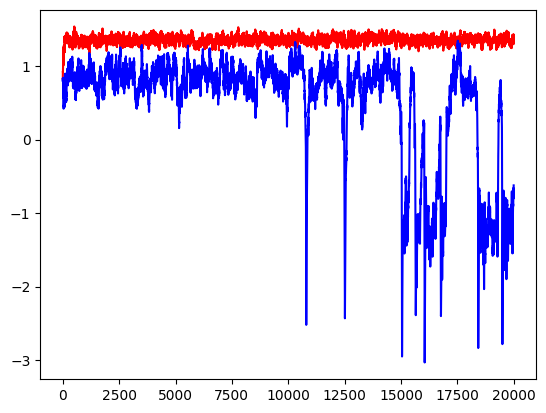

In [111]:
plt.plot(pred_mean[0:30000],'r')
plt.plot(actual_values[0:30000],'b')


In [164]:
np.random.randint(0,9,1)

array([6])

In [12]:
np.savez(r'/home/fabio/work/HM_and_AI_models/VAE_Model/predictions' ,
         predictions=pred_mean, mean_psi=mean_psi, std_psi=std_psi, actual_values=actual_values)